In [5]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('grayscale')

prefixo_dados = '201807151414'
random_state = 2018

In [6]:
import numpy as np
import pandas as pd

class Transformacao():
    def __init__(self):
        self.finalidades = np.array(['aluguel', 'venda'], dtype=object)
        self.tipos = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

    def transformar(self, X):
        X_novo = self._selecionar_atributos(X)
        
        finalidades_codificadas = self._codificar_finalidades(X_novo)
        tipos_codificados = self._codificar_tipos(X_novo)
       
        X_novo = self._unir_atributos(X_novo, [
            finalidades_codificadas,
            tipos_codificados,
        ])            
        
        X_novo = self._remover_atributos(X_novo)
        
        return X_novo
    
    def _selecionar_atributos(self, X):
        colunas = [
            'tipo_id',
            'finalidade',
            'preco',
            'area',
            'quartos',
            'suites',
            'banheiros',
            'vagas',
            'latitude',
            'longitude',
            'area_privativa',
        ]

        return X[colunas].copy()
     
    def _unir_atributos(self, X, atributos):
        return X.join(atributos)
    
    def _remover_atributos(self, X):
        return X.drop(['finalidade', 'finalidade_aluguel', 'tipo_id'], axis=1)
    
    def _codificar_finalidades(self, X):
        finalidades_prefixo = 'finalidade_'
        finalidades_codificadas = pd.get_dummies(X['finalidade'], prefix=finalidades_prefixo, prefix_sep='')
        finalidades_codificadas = finalidades_codificadas.T.reindex(finalidades_prefixo + self.finalidades).T.fillna(0)        
        return finalidades_codificadas
    
    def _codificar_tipos(self, X):
        tipos_prefixo = 'tipo_id_'
        tipos_colunas = [tipos_prefixo + str(x) for x in self.tipos]
        tipos_codificados = pd.get_dummies(X['tipo_id'], prefix=tipos_prefixo, prefix_sep='')
        tipos_codificados = tipos_codificados.T.reindex(tipos_colunas).T.fillna(0)
        return tipos_codificados

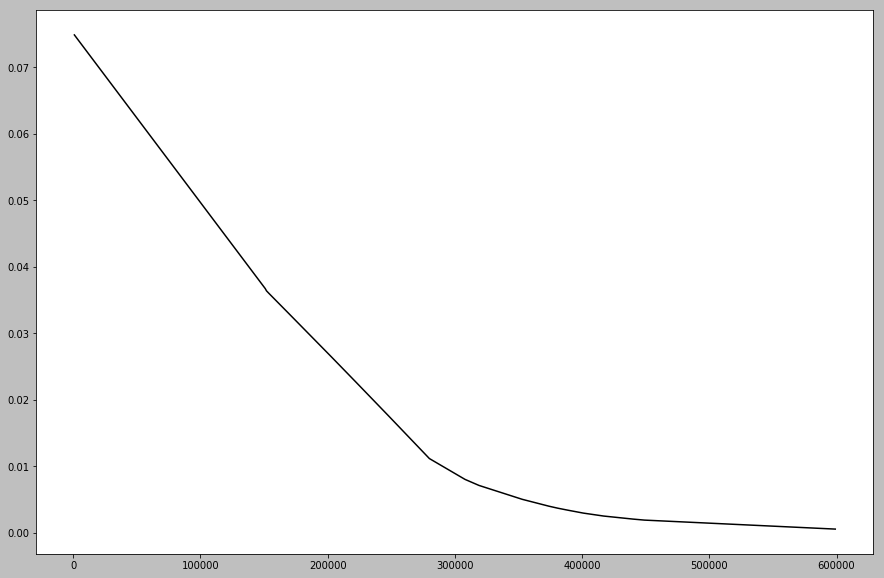

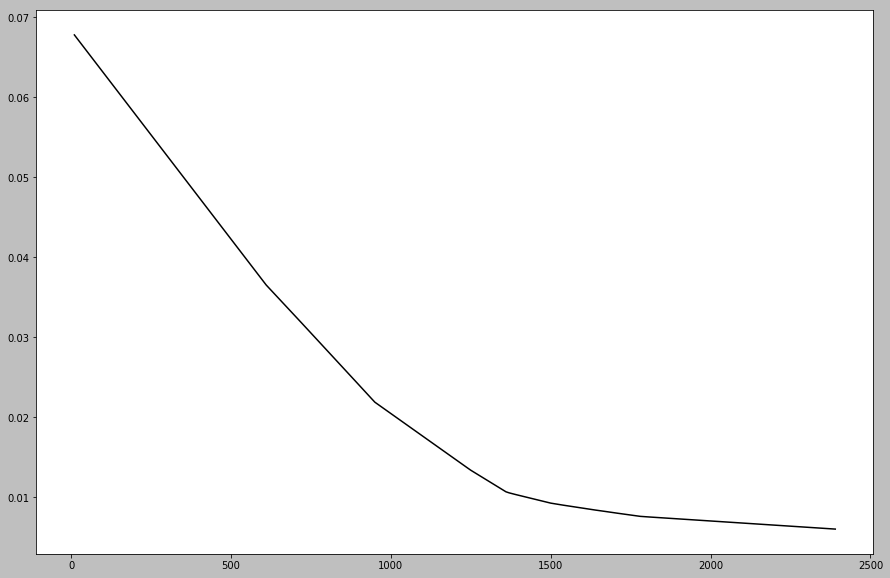

In [110]:
# try:
#   import unzip_requirements
# except ImportError:
#   pass

import xgboost as xgb
from scipy.signal import savgol_filter
import pandas as pd
import json
# from transformacao import Transformacao

def calcular(event, context):
    parametros = event.get('queryStringParameters', {})

    parametro_finalidade = parametros.get('finalidade')
    if parametro_finalidade not in ('venda', 'aluguel'):
        return {
            'statusCode': 400,
            'body': json.dumps({'mensagem': 'Finalidade deve ser "venda" ou "aluguel".'})
        }

    try:
        parametro_preco = int(parametros.get('preco'))
        parametro_area = int(parametros.get('area'))
        parametro_quartos = int(parametros.get('quartos'))
        parametro_suites = int(parametros.get('suites'))
        parametro_banheiros = int(parametros.get('banheiros'))
        parametro_vagas = int(parametros.get('vagas'))
        parametro_tipo_id = int(parametros.get('tipo_id'))
        parametro_latitude = float(parametros.get('latitude'))
        parametro_longitude = float(parametros.get('longitude'))
        parametro_area_privativa = int(parametros.get('area_privativa'))
    except (ValueError, TypeError):
        return {
            'statusCode': 400,
            'body': json.dumps({'mensagem': 'Parâmetro fornecido não está no formato esperado.'})
        }

    if (parametro_preco < 1 or parametro_area < 1 or parametro_quartos < 0 or
        parametro_suites < 0 or parametro_banheiros < 0 or parametro_vagas < 0  or
        parametro_tipo_id < 1):
        return {
            'statusCode': 400,
            'body': json.dumps({'mensagem': 'Parâmetro fornecido não está no intervalo esperado.'})
        }

   
    if parametro_finalidade == 'venda':
        passo = 1000
    else:
        passo = 10

    janela = int(np.ceil(parametro_preco / passo) // 2 * 2 + 1)
    
    imoveis = pd.DataFrame([{
        'preco': passo,
        'area': parametro_area,
        'quartos': parametro_quartos,
        'suites': parametro_suites,
        'banheiros': parametro_banheiros,
        'vagas': parametro_vagas,
        'finalidade': parametro_finalidade,
        'tipo_id': parametro_tipo_id,
        'latitude': parametro_latitude,
        'longitude': parametro_longitude,
        'area_privativa': parametro_area_privativa,
    }])
    
    for preco_simulado in range(passo * 2, parametro_preco * 2, passo):
        imoveis = imoveis.append({
            'preco': preco_simulado,
            'area': parametro_area,
            'quartos': parametro_quartos,
            'suites': parametro_suites,
            'banheiros': parametro_banheiros,
            'vagas': parametro_vagas,
            'finalidade': parametro_finalidade,
            'tipo_id': parametro_tipo_id,
            'latitude': parametro_latitude,
            'longitude': parametro_longitude,
            'area_privativa': parametro_area_privativa,
        }, ignore_index=True)

    modelo = xgb.Booster()
    modelo.load_model('modelos/201807151414-201807152034.model')

    transformacao = Transformacao()
    imoveis_transformados = transformacao.transformar(imoveis)
    
    atratividades = modelo.predict(xgb.DMatrix(imoveis_transformados))

    atratividades_filtradas = savgol_filter(atratividades, janela, 1)
    
    return {
        'statusCode': 200,
        'body': json.dumps({
            'precos': imoveis['preco'].tolist(),
            'atratividades':  list('{0:.9f}'.format(f) for f in atratividades_filtradas)
        })
    }
    
tvenda = {
    "queryStringParameters" : {
        "preco": 300000,
        "area": 77,
        "quartos": 3,
        "suites": 1,
        "banheiros": 2,
        "vagas": 1,
        "finalidade": "venda",
        "tipo_id": 1,
        "latitude": -19.8750115,
        "longitude": -43.917761,
        "area_privativa": 0,
    },
}

taluguel = {
    "queryStringParameters" : {
        "preco": 1200,
        "area": 77,
        "quartos": 3,
        "suites": 1,
        "banheiros": 2,
        "vagas": 1,
        "finalidade": "aluguel",
        "tipo_id": 1,
        "latitude": -19.8750115,
        "longitude": -43.917761,
        "area_privativa": 0,
    },
}

tvendares = json.loads(calcular(tvenda, {})['body'])
taluguelres = json.loads(calcular(taluguel, {})['body'])


plt.figure(figsize=(15,10))
plt.plot(tvendares['precos'], np.array(tvendares['atratividades'], dtype=float))
plt.show()

plt.figure(figsize=(15,10))
plt.plot(taluguelres['precos'], np.array(taluguelres['atratividades'], dtype=float))
plt.show()

In [111]:
!pip3 freeze

attrs==18.1.0
bleach==2.1.2
boostaroota==1.3
Boruta==0.1.5
branca==0.2.0
certifi==2017.11.5
chardet==3.0.4
colour==0.1.5
cycler==0.10.0
decorator==4.1.2
eli5==0.8
entrypoints==0.2.3
folium==0.5.0
graphviz==0.8.4
html5lib==1.0.1
idna==2.6
ipykernel==4.7.0
ipython==6.2.1
ipython-genutils==0.2.0
ipywidgets==7.0.5
jedi==0.11.0
Jinja2==2.10
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.1.0
jupyter-console==5.2.0
jupyter-core==4.4.0
lightgbm==2.1.2
MarkupSafe==1.0
matplotlib==2.1.0
mistune==0.8.3
mpltex==0.5.1
nbconvert==5.3.1
nbformat==4.4.0
notebook==5.2.2
numpy==1.13.3
palettable==3.1.1
pandas==0.21.0
pandocfilters==1.4.2
parso==0.1.0
patsy==0.5.0
pexpect==4.3.0
pickleshare==0.7.4
prompt-toolkit==1.0.15
ptyprocess==0.5.2
Pygments==2.2.0
pyparsing==2.2.0
python-dateutil==2.6.1
pytz==2017.3
pyzmq==16.0.3
qtconsole==4.3.1
requests==2.18.4
scikit-learn==0.19.1
scipy==1.0.0
seaborn==0.8.1
simplegeneric==0.8.1
singledispatch==3.4.0.3
six==1.11.0
sklearn==0.0
statsmodels==0.9.0
tabulate==0.